Random Forest Model


=== Test Results ===
LOG SCALE:
  MSE:  0.020699
  RMSE: 0.143871
  MAE:  0.076228
  R²:   0.980190

LINEAR SCALE:
  MSE:  1117.860115
  RMSE: 33.434415
  MAE:  7.811733
  R²:   0.908399

=== Cross-Validation Results (Log scale) ===
R² (mean ± std):  0.980583 ± 0.004692
MSE (mean ± std): 0.020298 ± 0.004782


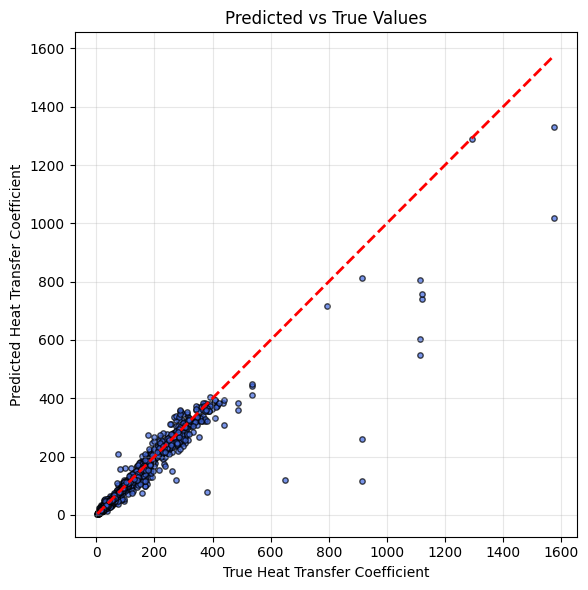

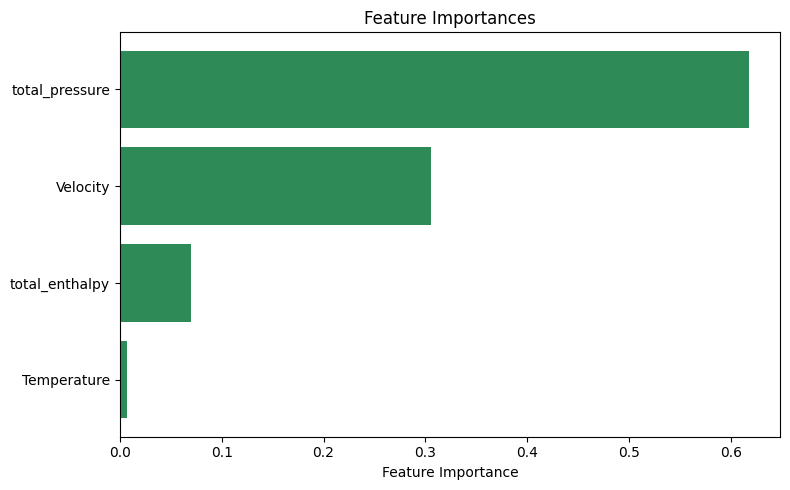


=== Top Features by Importance ===
 1. total_pressure             Importance: 0.6174
 2. Velocity                   Importance: 0.3053
 3. total_enthalpy             Importance: 0.0699
 4. Temperature                Importance: 0.0074


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('master_data.csv')

target_column = 'heat_transfer_coef'
X = df.drop(columns=[target_column])
y = df[target_column]
X = X.select_dtypes(include='number')

# perform log-transform on the target
y_log = np.log1p(y)  # log(1 + h) avoids log(0)

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data 70/30
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.3, random_state=42
)

# train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_log)

# make predictions
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# compute rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# log
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = rmse(y_test_log, y_pred_log)
mae_log = mean_absolute_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

# linear
mse_lin = mean_squared_error(y_test, y_pred)
rmse_lin = rmse(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
r2_lin = r2_score(y_test, y_pred)

print("\n=== Test Results ===")
print(f"LOG SCALE:")
print(f"  MSE:  {mse_log:.6f}")
print(f"  RMSE: {rmse_log:.6f}")
print(f"  MAE:  {mae_log:.6f}")
print(f"  R²:   {r2_log:.6f}")

print(f"\nLINEAR SCALE:")
print(f"  MSE:  {mse_lin:.6f}")
print(f"  RMSE: {rmse_lin:.6f}")
print(f"  MAE:  {mae_lin:.6f}")
print(f"  R²:   {r2_lin:.6f}")

# KFOLD CROSS VALIDATION
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(model, X_scaled, y_log, cv=kf, scoring='r2')
cv_mse_scores = -cross_val_score(model, X_scaled, y_log, cv=kf, scoring='neg_mean_squared_error')

print("\n=== Cross-Validation Results (Log scale) ===")
print(f"R² (mean ± std):  {cv_r2_scores.mean():.6f} ± {cv_r2_scores.std():.6f}")
print(f"MSE (mean ± std): {cv_mse_scores.mean():.6f} ± {cv_mse_scores.std():.6f}")

# plot results
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=15, alpha=0.7, color='royalblue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Heat Transfer Coefficient")
plt.ylabel("Predicted Heat Transfer Coefficient")
plt.title("Predicted vs True Values")
#plt.xlim(0, 400)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# feature importance
feature_importances = model.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]
sorted_features = feature_names[sorted_idx]

# Plot
plt.figure(figsize=(8,5))
plt.barh(sorted_features, sorted_importances, color='seagreen')
plt.xlabel("Feature Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print results
print("\n=== Top Features by Importance ===")
for i in range(min(10, len(sorted_features))):
    print(f"{i+1:2d}. {sorted_features[i]:<25}  Importance: {sorted_importances[i]:.4f}")


Plot predictions

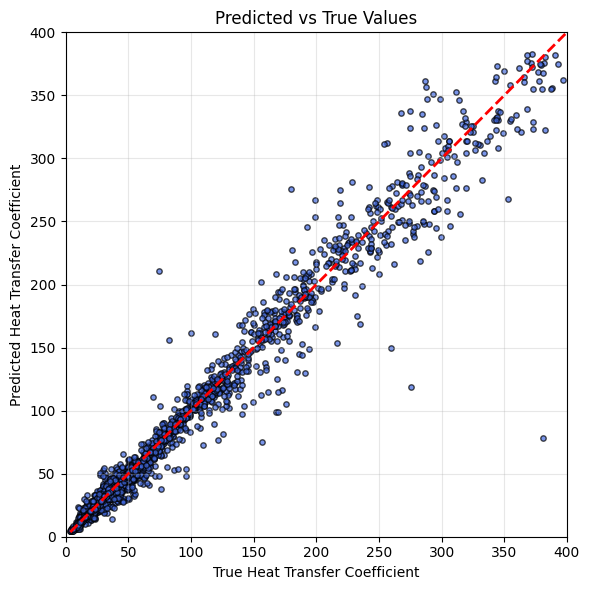

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=15, alpha=0.7, color='royalblue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Heat Transfer Coefficient")
plt.ylabel("Predicted Heat Transfer Coefficient")
plt.title("Predicted vs True Values")
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Write all predictions to excel file

In [10]:
# Use all original rows and columns
X_numeric = df[X.columns]  # numeric columns used for training

# Scale features
X_scaled_full = scaler.transform(X_numeric)

# Make predictions
y_pred_log_full = model.predict(X_scaled_full)
y_pred_full = np.expm1(y_pred_log_full)

df_predictions = df.copy()
df_predictions['predicted_h'] = y_pred_full

# Save file
output_csv = 'master_data_predictions_only.csv'
df_predictions.to_csv(output_csv, index=False)

print(f"All predictions saved with original columns to '{output_csv}'.")


All predictions saved with original columns to 'master_data_predictions_only.csv'.


Compare results to correlations

Rows after cleaning and filtering: 3400


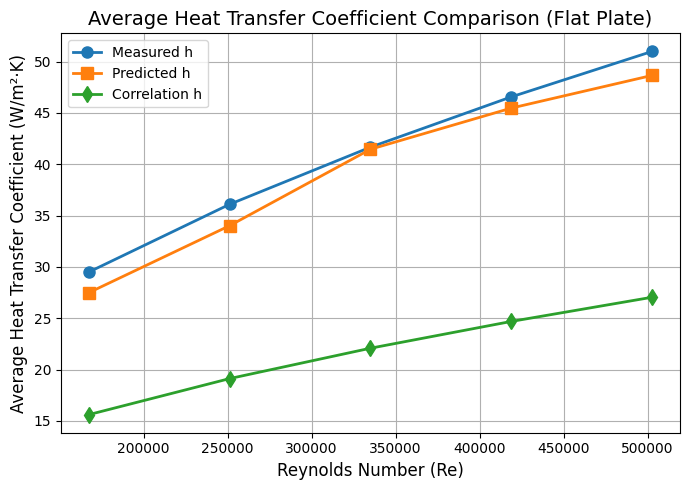


Final Averaged Data:
         Re  h_measured  h_predicted  h_correlation
0  167500.0   29.507650    27.497521      15.610886
1  251250.0   36.103368    34.019973      19.119352
2  335000.0   41.663285    41.461061      22.077126
3  418750.0   46.560057    45.467768      24.682977
4  502500.0   50.987495    48.652301      27.038847
------------------------------------------------------------
Rows after cleaning and filtering: 6498


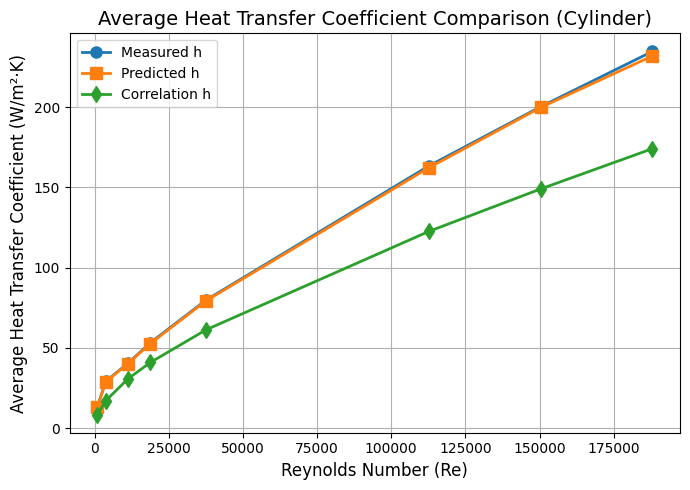


Final Averaged Data:
              Re  h_measured  h_predicted  h_correlation
0     939.940532   13.226840    13.025330       8.395048
1    3759.762127   29.141032    28.791078      17.052728
2   11279.286381   40.418905    40.156674      30.714078
3   18798.810636   53.178582    52.646955      40.869679
4   37597.621272   79.778151    79.312105      61.247277
5  112792.863815  163.451970   162.311044     122.624024
6  150390.485087  200.247759   199.756743     149.009426
7  187988.106358  234.651279   231.825994     174.051435
------------------------------------------------------------


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_dataset(filename, re_col, h_measured_col, title, threshold=2000):
    """
    Processes a dataset to:
    1. Filter out invalid h values.
    2. Detect distinct runs based on Temperature/Velocity.
    3. Compute per-run averages.
    4. Average by unique Reynolds number.
    5. Plot results and return averaged table.
    """

    # Load Data
    if filename.endswith('.csv'):
        data = pd.read_csv(filename)
    else:
        data = pd.read_excel(filename)

    # Convert 'h_correlation' to numeric if needed
    data['h_correlation'] = pd.to_numeric(data['h_correlation'], errors='coerce')
    clean_data = data.dropna(subset=['h_correlation']).copy()

    # Optional filter for h <= threshold
    mask = (clean_data[h_measured_col] <= threshold) & (clean_data['predicted_h'] <= threshold)
    filtered = clean_data[mask].reset_index(drop=True)

    print(f"Rows after cleaning and filtering: {len(filtered)}")

    # Detection based on velocity or temperature change
    run_id = np.zeros(len(filtered), dtype=int)
    run_counter = 1
    run_id[0] = run_counter

    for i in range(1, len(filtered)):
        if (filtered.loc[i, 'Temperature'] != filtered.loc[i - 1, 'Temperature']) or \
           (filtered.loc[i, 'Velocity'] != filtered.loc[i - 1, 'Velocity']):
            run_counter += 1
        run_id[i] = run_counter

    filtered['RunID'] = run_id

    # Compute  Average
    run_groups = filtered.groupby('RunID')
    avg_Re_run = run_groups[re_col].mean()
    avg_h_measured_run = run_groups[h_measured_col].mean()
    avg_h_predicted_run = run_groups['predicted_h'].mean()
    avg_h_correlation_run = run_groups['h_correlation'].mean()

    run_avg_df = pd.DataFrame({
        'Re': avg_Re_run,
        'h_measured': avg_h_measured_run,
        'h_predicted': avg_h_predicted_run,
        'h_correlation': avg_h_correlation_run
    })

    # average by unique Reynolds number
    final_avg = run_avg_df.groupby('Re', as_index=False).mean()

    plt.figure(figsize=(7, 5))
    plt.plot(final_avg['Re'], final_avg['h_measured'], 'o-', linewidth=2, markersize=8, label='Measured h')
    plt.plot(final_avg['Re'], final_avg['h_predicted'], 's-', linewidth=2, markersize=8, label='Predicted h')
    plt.plot(final_avg['Re'], final_avg['h_correlation'], 'd-', linewidth=2, markersize=8, label='Correlation h')
    plt.xlabel('Reynolds Number (Re)', fontsize=12)
    plt.ylabel('Average Heat Transfer Coefficient (W/m²·K)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nFinal Averaged Data:")
    print(final_avg)
    print("-" * 60)

    return final_avg


# flat plate data
flat_plate_file = 'flat_plate_comparisons.csv'
flat_plate_results = process_dataset(
    filename=flat_plate_file,
    re_col='Re_local',
    h_measured_col='heat_transfer_coef',
    title='Average Heat Transfer Coefficient Comparison (Flat Plate)',
    threshold=2000
)

# cylinder data
cylinder_file = 'master_data_cylinder_with_local_Re.xlsx'
cylinder_results = process_dataset(
    filename=cylinder_file,
    re_col='Re_D',
    h_measured_col='h_measured',
    title='Average Heat Transfer Coefficient Comparison (Cylinder)',
    threshold=2000
)


Calculate percent error

In [12]:
import pandas as pd
import numpy as np

# Percent error calculations for both geometries

def compute_percent_error(df, case_name):
    """
    Compute percent errors between predicted and measured h,
    and correlation and measured h for each Reynolds number.
    """
    df = df.copy()
    df['Error_predicted'] = 100 * np.abs((df['h_predicted'] - df['h_measured']) / df['h_measured'])
    df['Error_correlation'] = 100 * np.abs((df['h_correlation'] - df['h_measured']) / df['h_measured'])
    df['Case'] = case_name
    return df[['Case', 'Re', 'Error_predicted', 'Error_correlation']]

flat_plate_errors = compute_percent_error(flat_plate_results, 'Flat Plate')
cylinder_errors = compute_percent_error(cylinder_results, 'Cylinder')

# combine results
comparison_table = pd.concat([flat_plate_errors, cylinder_errors], ignore_index=True)


mean_errors = comparison_table.groupby('Case')[['Error_predicted', 'Error_correlation']].mean().reset_index()

print("\nDetailed Percent Error per Reynolds Number:")
print(comparison_table.to_string(index=False, justify='center', col_space=12))
print("\nAverage Percent Error per Case:")
print(mean_errors.to_string(index=False, justify='center', col_space=12))



Detailed Percent Error per Reynolds Number:
    Case           Re       Error_predicted  Error_correlation
 Flat Plate  167500.000000     6.812230         47.095464     
 Flat Plate  251250.000000     5.770639         47.042746     
 Flat Plate  335000.000000     0.485378         47.010597     
 Flat Plate  418750.000000     2.345979         46.986798     
 Flat Plate  502500.000000     4.579935         46.969650     
   Cylinder     939.940532     1.523493         36.530210     
   Cylinder    3759.762127     1.200899         41.482071     
   Cylinder   11279.286381     0.648785         24.010613     
   Cylinder   18798.810636     0.999701         23.146354     
   Cylinder   37597.621272     0.584178         23.228006     
   Cylinder  112792.863815     0.698019         24.978558     
   Cylinder  150390.485087     0.245204         25.587469     
   Cylinder  187988.106358     1.204036         25.825491     

Average Percent Error per Case:
    Case      Error_predicted  Error_cor

Plot all CFD data

Plotting 9898 valid data points (excluded zeros).


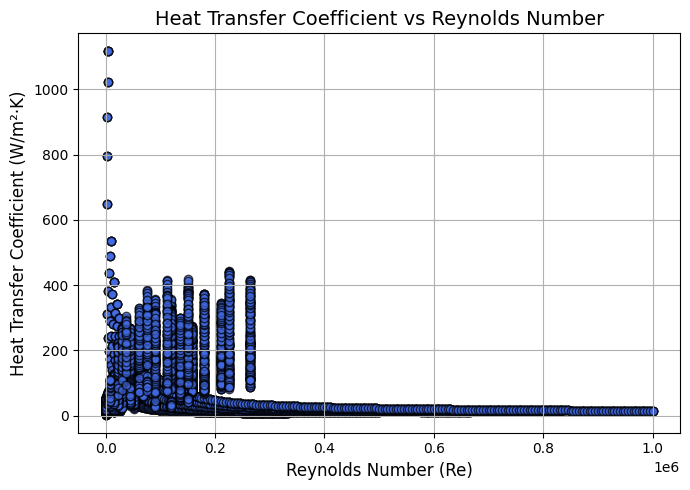

Plotting 9898 valid data points (excluded zeros and negatives).


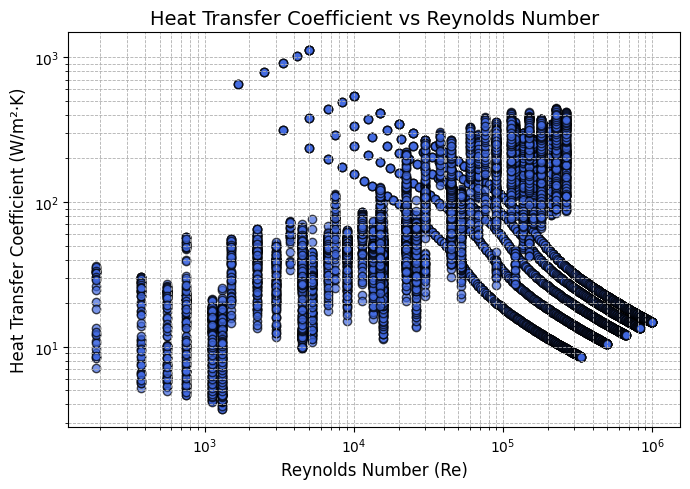

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# plot heat transfer coefficient v reynolds

filename = 'master_data_withRe.csv'
data = pd.read_csv(filename)

# remove Re = 0
filtered = data[(data['Re'] != 0) & (data['heat_transfer_coef'] != 0)]
print(f"Plotting {len(filtered)} valid data points (excluded zeros).")

plt.figure(figsize=(7, 5))
plt.scatter(filtered['Re'], filtered['heat_transfer_coef'],
            color='royalblue', edgecolors='k', alpha=0.7)

plt.xlabel('Reynolds Number (Re)', fontsize=12)
plt.ylabel('Heat Transfer Coefficient (W/m²·K)', fontsize=12)
plt.title('Heat Transfer Coefficient vs Reynolds Number', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# log scale additional plot

filename = 'master_data_withRe.csv'
data = pd.read_csv(filename)

# remove Re = 0-
filtered = data[(data['Re'] > 0) & (data['heat_transfer_coef'] > 0)]
print(f"Plotting {len(filtered)} valid data points (excluded zeros and negatives).")

plt.figure(figsize=(7, 5))
plt.scatter(filtered['Re'], filtered['heat_transfer_coef'],
            color='royalblue', edgecolors='k', alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reynolds Number (Re)', fontsize=12)
plt.ylabel('Heat Transfer Coefficient (W/m²·K)', fontsize=12)
plt.title('Heat Transfer Coefficient vs Reynolds Number', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()


Save all plots

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

save_dir = r"C:\Users\malinc2\Desktop\Final Machine Learning Project"
os.makedirs(save_dir, exist_ok=True)  # create folder if it doesn't exist

def save_figure(fig, filename):
    save_path = os.path.join(save_dir, filename)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Figure saved to: {save_path}")
